<a href="https://colab.research.google.com/github/gndumbri/FindMyPhoto/blob/master/Final_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://venkateshnarayanan.wordpress.com/2019/08/26/simple-web-app-with-flask-in-windows/

Sources

1. https://mc.ai/tutorial-image-classification-with-keras-flow_from_directory-and-generators/

2. https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

3. https://towardsdatascience.com/transfer-learning-using-mobilenet-and-keras-c75daf7ff299

In [39]:
from google.colab import drive
drive.mount('/content/drive') # comment one more change
# different line

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%tensorflow_version 2.x
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, InputLayer, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import warnings
warnings.filterwarnings('ignore')

Variables to use for Data Processing and Modeling

In [0]:
preddir = '/content/drive/My Drive/pred'
traindir = '/content/drive/My Drive/Findmyphoto/train'
valdir = '/content/drive/My Drive/Findmyphoto/val'

IMG_SIZE = 160
batch_size = 32
epochs = 30

Functions

In [0]:
def show_predictions(model, preddir, IMG_SIZE, training_data, val):
    pred = ImageDataGenerator(rescale=1./255)
    pred = pred.flow_from_directory(
        preddir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=len(val.classes),
        shuffle=False
        )
    predictions = model.predict(pred, steps=1)
    preds = np.argmax(predictions,axis=1) # code from source 1
    labels = (training_data.class_indices) # code from source 1
    labels = dict((v,k) for k,v in labels.items()) # code from source 1
    return [labels[k] for k in preds]

In [0]:
def run_model(model, train_data, val_data, batch_size, epochs):
    history = model.fit(
        train_data,
        steps_per_epoch=309//batch_size,
        epochs=epochs,
        validation_data=val_data, 
        validation_steps=118//batch_size
        )
    return history

In [0]:
def plot_confusion_matrix(IMG_SIZE, val_gen, valdir, model, prediction_data_gen):
    plt.rcParams.update({'font.size': 11})
    
    predictions = model.predict(prediction_data_gen, steps=1)
    preds = np.argmax(predictions,axis=1)
    predictions = tf.nn.softmax(predictions, axis=1)
    
    labels = (val_gen.classes)
    
    plot_labels = np.array([i for i in (val_gen.class_indices).keys()])
    
    cm = tf.math.confusion_matrix(labels, preds)

    ratio_correct = np.trace(cm)/np.sum(cm)
    ratio_incorrect = 1 - ratio_correct

    plt.figure(figsize=(10,8))
    plt.imshow(cm, interpolation='nearest', cmap='Reds')
    plt.colorbar()

    if labels is not None:
        ticks = np.arange(len(plot_labels))
        plt.xticks(ticks, plot_labels, rotation=90)
        plt.yticks(ticks, plot_labels)

    threshold = 4
    for i, j in itertools.product(
        range(cm.shape[0]), 
        range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i,j]),
                 horizontalalignment='center',
                 color='white' if cm[i,j] > threshold else 'black')
    
    plt.tight_layout()
    plt.ylabel('Predicted')
    plt.xlabel('True Label\naccuracy={:0.4f}; ratio_incorrect={:0.4f}'.format(
        ratio_correct, ratio_incorrect
    ))

In [0]:
def report(IMG_SIZE, val_gen, valdir, model, prediction_data_gen):
    predictions = model.predict(prediction_data_gen, steps=1)
    preds = np.argmax(predictions,axis=1)
    labels = (val_gen.classes)
    return pd.DataFrame.from_dict(
        classification_report(labels, preds, output_dict=True))


In [0]:
def find_my_photo(predictions, df):
    answer = df.loc[df['name'] == predictions[0], 'coord']
    return ''.join(list(answer))

Data Augmentation

In [0]:
image_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    horizontal_flip=True,
    zoom_range=0.5,
    shear_range=0.3,
    height_shift_range=.15,
    width_shift_range=.15
)

val_gen = ImageDataGenerator(rescale=1./255)

pred_gen = ImageDataGenerator(rescale=1./255)

Create Data Generators

In [12]:
train = image_gen_train.flow_from_directory(
    traindir,
    target_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=batch_size
    )

val = val_gen.flow_from_directory(
    valdir, 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size
    )

# to be used later for predictions
prediction_data_gen = pred_gen.flow_from_directory(
    valdir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=len(val.classes),
    shuffle=False
    )

Found 309 images belonging to 33 classes.
Found 116 images belonging to 33 classes.
Found 116 images belonging to 33 classes.


Building my own model

In [0]:
model_a = Sequential([
        Conv2D(32, (5,5), padding='same', activation='relu'),
        MaxPooling2D(2,2),
        Dropout(0.3),
        Conv2D(64, (3,3), padding='same', activation='relu'),
        MaxPooling2D(2,2),
        Dropout(0.2),
        Conv2D(64, (3,3), padding='same', activation='relu'),
        MaxPooling2D(2,2),
        Dropout(0.2),
        Conv2D(128, (3,3), padding='same', activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(33)
        
])

model_a.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [14]:
run_model(model_a, train, val, batch_size, epochs)

Epoch 1/30
9/9 [==============================] - 302s 34s/step - loss: 3.6232 - accuracy: 0.0278 - val_loss: 3.4821 - val_accuracy: 0.0729
Epoch 2/30
9/9 [==============================] - 7s 759ms/step - loss: 3.4572 - accuracy: 0.0397 - val_loss: 3.4328 - val_accuracy: 0.0833
Epoch 3/30
9/9 [==============================] - 7s 755ms/step - loss: 3.4816 - accuracy: 0.0505 - val_loss: 3.4660 - val_accuracy: 0.0833
Epoch 4/30
9/9 [==============================] - 6s 707ms/step - loss: 3.4300 - accuracy: 0.0397 - val_loss: 3.4393 - val_accuracy: 0.1146
Epoch 5/30
9/9 [==============================] - 7s 780ms/step - loss: 3.4457 - accuracy: 0.0686 - val_loss: 3.4480 - val_accuracy: 0.1562
Epoch 6/30
9/9 [==============================] - 7s 769ms/step - loss: 3.4185 - accuracy: 0.0686 - val_loss: 3.3420 - val_accuracy: 0.1875
Epoch 7/30
9/9 [==============================] - 7s 732ms/step - loss: 3.3006 - accuracy: 0.1155 - val_loss: 3.2308 - val_accuracy: 0.1042
Epoch 8/30
9/9 [====

Transfer Learning with MobileNet

In [15]:
mobilenet_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet')

mobilenet_model.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
mobile_model = tf.keras.Sequential([
        mobilenet_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dense(33)
])

learning_rate = 0.0001

mobile_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=learning_rate),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [17]:
run_model(mobile_model, train, val, batch_size, epochs)

Epoch 1/30
9/9 [==============================] - 7s 820ms/step - loss: 3.7394 - accuracy: 0.0505 - val_loss: 3.5336 - val_accuracy: 0.1042
Epoch 2/30
9/9 [==============================] - 7s 756ms/step - loss: 3.3202 - accuracy: 0.1076 - val_loss: 3.2571 - val_accuracy: 0.1875
Epoch 3/30
9/9 [==============================] - 7s 775ms/step - loss: 3.0771 - accuracy: 0.1733 - val_loss: 3.0896 - val_accuracy: 0.2188
Epoch 4/30
9/9 [==============================] - 7s 731ms/step - loss: 2.8979 - accuracy: 0.2491 - val_loss: 3.0138 - val_accuracy: 0.2188
Epoch 5/30
9/9 [==============================] - 7s 723ms/step - loss: 2.7084 - accuracy: 0.3213 - val_loss: 2.8122 - val_accuracy: 0.2812
Epoch 6/30
9/9 [==============================] - 7s 747ms/step - loss: 2.5417 - accuracy: 0.3574 - val_loss: 2.6250 - val_accuracy: 0.3958
Epoch 7/30
9/9 [==============================] - 7s 734ms/step - loss: 2.3561 - accuracy: 0.4404 - val_loss: 2.5134 - val_accuracy: 0.4688
Epoch 8/30
9/9 [====

Transfer Learning with ResNet

In [18]:
resnet_model = tf.keras.applications.ResNet50V2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet')

94674944/94668760 [==============================] - 1s 0us/step


In [0]:
resnet_model.trainable=False

In [0]:
res_model = tf.keras.Sequential([
                    resnet_model,
                    GlobalAveragePooling2D(),
                    Dense(33)
                    ])

res_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
              )

In [21]:
run_model(res_model, train, val, batch_size, epochs)

Epoch 1/30
9/9 [==============================] - 7s 788ms/step - loss: 3.7399 - accuracy: 0.1047 - val_loss: 2.7422 - val_accuracy: 0.2708
Epoch 2/30
9/9 [==============================] - 7s 756ms/step - loss: 2.4584 - accuracy: 0.3357 - val_loss: 1.9237 - val_accuracy: 0.4896
Epoch 3/30
9/9 [==============================] - 7s 766ms/step - loss: 1.7729 - accuracy: 0.5035 - val_loss: 1.4577 - val_accuracy: 0.5833
Epoch 4/30
9/9 [==============================] - 7s 771ms/step - loss: 1.2039 - accuracy: 0.7401 - val_loss: 1.2197 - val_accuracy: 0.6354
Epoch 5/30
9/9 [==============================] - 7s 761ms/step - loss: 0.9068 - accuracy: 0.7942 - val_loss: 1.0090 - val_accuracy: 0.7292
Epoch 6/30
9/9 [==============================] - 7s 771ms/step - loss: 0.8373 - accuracy: 0.7942 - val_loss: 0.8858 - val_accuracy: 0.7708
Epoch 7/30
9/9 [==============================] - 7s 743ms/step - loss: 0.7271 - accuracy: 0.8303 - val_loss: 0.8799 - val_accuracy: 0.7188
Epoch 8/30
9/9 [====

Assessing Models

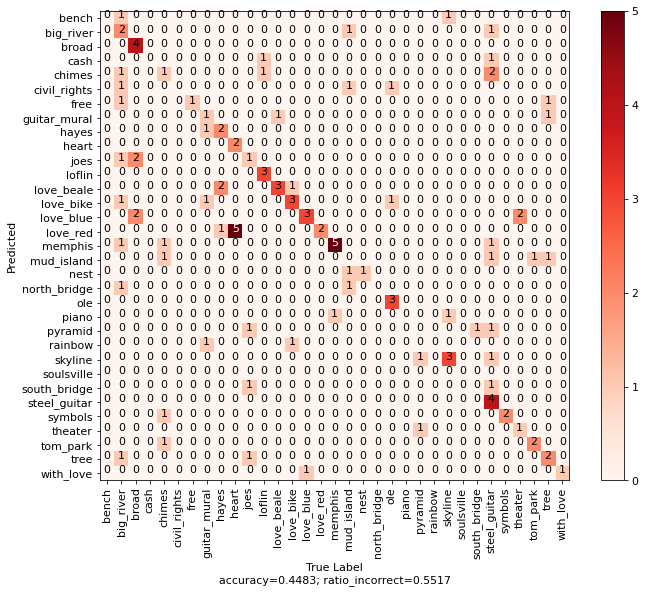

In [22]:
plot_confusion_matrix(IMG_SIZE, val, valdir, model_a, prediction_data_gen)

In [25]:
report(IMG_SIZE, val, valdir, model_a, prediction_data_gen)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,26,27,28,29,30,31,32,accuracy,macro avg,weighted avg
precision,0.0,0.181818,0.500000,0.0,0.2,0.0,1.000000,0.250000,0.400000,0.285714,0.25,0.60,0.75,0.600000,0.750000,1.00,0.833333,0.0,1.000000,0.0,0.60,0.0,0.0,0.0,0.6,0.0,0.307692,1.000000,0.333333,0.666667,0.400000,1.000000,0.448276,0.422142,0.494507
recall,0.0,0.500000,1.000000,0.0,0.2,0.0,0.333333,0.333333,0.666667,1.000000,0.25,1.00,0.50,0.500000,0.428571,0.25,0.625000,0.0,0.500000,0.0,1.00,0.0,0.0,0.0,0.6,0.0,1.000000,0.666667,0.500000,0.666667,0.500000,0.500000,0.448276,0.422507,0.448276
f1-score,0.0,0.266667,0.666667,0.0,0.2,0.0,0.500000,0.285714,0.500000,0.444444,0.25,0.75,0.60,0.545455,0.545455,0.40,0.714286,0.0,0.666667,0.0,0.75,0.0,0.0,0.0,0.6,0.0,0.470588,0.800000,0.400000,0.666667,0.444444,0.666667,0.448276,0.379179,0.423374
support,2.0,4.000000,4.000000,2.0,5.0,3.0,3.000000,3.000000,3.000000,2.000000,4.00,3.00,6.00,6.000000,7.000000,8.00,8.000000,4.0,2.000000,2.0,3.00,2.0,3.0,2.0,5.0,2.0,4.000000,3.000000,2.000000,3.000000,4.000000,2.000000,0.448276,116.000000,116.000000


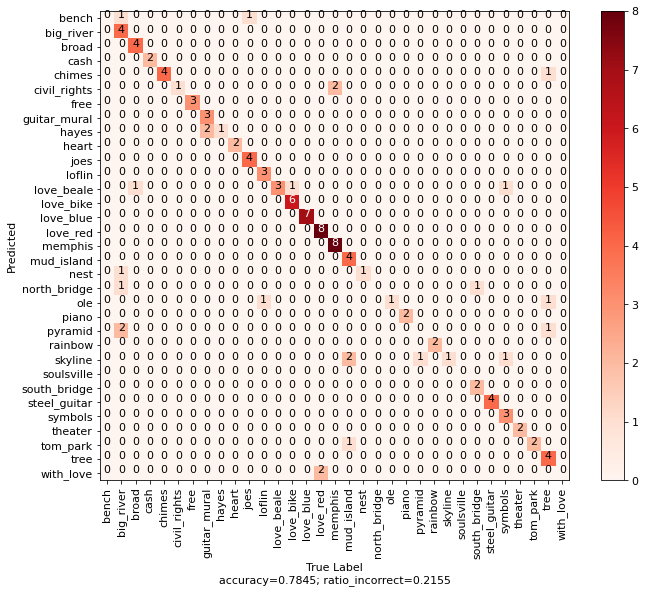

In [26]:
plot_confusion_matrix(IMG_SIZE, val, valdir, mobile_model, prediction_data_gen)

In [27]:
report(IMG_SIZE, val, valdir, mobile_model, prediction_data_gen)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,26,27,28,29,30,31,32,accuracy,macro avg,weighted avg
precision,0.0,0.444444,0.800000,1.0,1.000000,1.000000,1.0,0.60,1.000000,1.0,0.800000,0.750000,1.000000,0.857143,1.0,0.800000,0.800000,0.571429,1.000000,0.0,1.000000,1.0,0.0,1.0,1.000000,0.666667,1.0,0.60,1.0,1.000000,0.571429,0.0,0.784483,0.758160,0.792029
recall,0.0,1.000000,1.000000,1.0,0.800000,0.333333,1.0,1.00,0.333333,1.0,1.000000,1.000000,0.500000,1.000000,1.0,1.000000,1.000000,1.000000,0.500000,0.0,0.333333,1.0,0.0,1.0,0.200000,1.000000,1.0,1.00,1.0,0.666667,1.000000,0.0,0.784483,0.739583,0.784483
f1-score,0.0,0.615385,0.888889,1.0,0.888889,0.500000,1.0,0.75,0.500000,1.0,0.888889,0.857143,0.666667,0.923077,1.0,0.888889,0.888889,0.727273,0.666667,0.0,0.500000,1.0,0.0,1.0,0.333333,0.800000,1.0,0.75,1.0,0.800000,0.727273,0.0,0.784483,0.705039,0.742822
support,2.0,4.000000,4.000000,2.0,5.000000,3.000000,3.0,3.00,3.000000,2.0,4.000000,3.000000,6.000000,6.000000,7.0,8.000000,8.000000,4.000000,2.000000,2.0,3.000000,2.0,3.0,2.0,5.000000,2.000000,4.0,3.00,2.0,3.000000,4.000000,2.0,0.784483,116.000000,116.000000


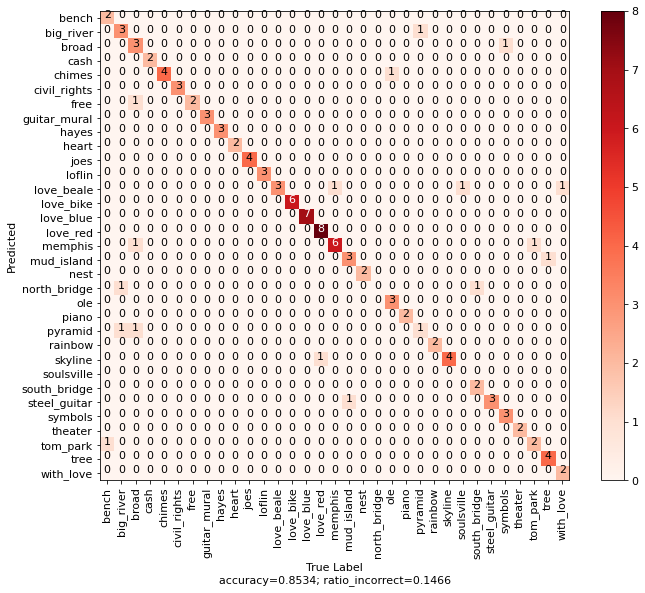

In [28]:
plot_confusion_matrix(IMG_SIZE, val, valdir, res_model, prediction_data_gen)

In [29]:
report(IMG_SIZE, val, valdir, res_model, prediction_data_gen)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,accuracy,macro avg,weighted avg
precision,0.666667,0.600000,0.50,1.0,1.000000,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,0.888889,0.857143,0.75,1.0,0.0,0.750000,1.0,0.500000,1.0,1.000000,0.0,0.666667,1.000000,0.750000,1.0,0.666667,0.800000,0.666667,0.853448,0.820082,0.866968
recall,1.000000,0.750000,0.75,1.0,0.800000,1.0,0.666667,1.0,1.0,1.0,1.0,1.0,0.500000,1.0,1.0,1.000000,0.750000,0.75,1.0,0.0,1.000000,1.0,0.333333,1.0,0.800000,0.0,1.000000,0.750000,1.000000,1.0,0.666667,1.000000,1.000000,0.853448,0.833838,0.853448
f1-score,0.800000,0.666667,0.60,1.0,0.888889,1.0,0.800000,1.0,1.0,1.0,1.0,1.0,0.666667,1.0,1.0,0.941176,0.800000,0.75,1.0,0.0,0.857143,1.0,0.400000,1.0,0.888889,0.0,0.800000,0.857143,0.857143,1.0,0.666667,0.888889,0.800000,0.853448,0.816039,0.848379
support,2.000000,4.000000,4.00,2.0,5.000000,3.0,3.000000,3.0,3.0,2.0,4.0,3.0,6.000000,6.0,7.0,8.000000,8.000000,4.00,2.0,2.0,3.000000,2.0,3.000000,2.0,5.000000,0.0,2.000000,4.000000,3.000000,2.0,3.000000,4.000000,2.000000,0.853448,116.000000,116.000000


Predictions

In [30]:
location_1 = show_predictions(model_a, preddir, IMG_SIZE, train, val)
location_2 = show_predictions(mobile_model, preddir, IMG_SIZE, train, val)
location_3 = show_predictions(res_model, preddir, IMG_SIZE, train, val)

Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.


Getting lat/long for image

In [36]:
find_my_photo(location_1, pd.read_csv(r'/content/drive/My Drive/key.csv')).replace(' ', '')

'35.129059,-90.075649'

In [37]:
find_my_photo(location_2, pd.read_csv(r'/content/drive/My Drive/key.csv')).replace(' ', '')

'35.132173,-90.066536'

In [38]:
find_my_photo(location_3, pd.read_csv(r'/content/drive/My Drive/key.csv')).replace(' ', '')

'35.145345,-90.058976'

All found the right image, since mobile_model had best accuracy, I will use that result for the image retrieval

In [0]:
street_view = find_my_photo(location_2, pd.read_csv(r'/content/drive/My Drive/key.csv')).replace(' ', '')

In [35]:
street_view

'35.132173,-90.066536'